# Image Classification

### Building and training a CNN that can accurately identify images of cats and dogs.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Preparation

In [3]:
# # Organize data into train, valid, test dirs

# os.chdir('/content/drive/MyDrive/kaggle/dogs-vs-cats/train') # change directory
# if os.path.isdir('train/dog') is False:
#     os.makedirs('train/dog')
#     os.makedirs('train/cat')
#     os.makedirs('valid/dog')
#     os.makedirs('valid/cat')
#     os.makedirs('test/dog')
#     os.makedirs('test/cat')

#     # We have too large of a dataset, so we are only using a subset of the data
#     # 1000 images in the trainig set, 200 images in the validation set, and 100 images in the test set

#     for i in random.sample(glob.glob('cat*'), 500):
#         shutil.move(i, 'train/cat')
#     for i in random.sample(glob.glob('dog*'), 500):
#         shutil.move(i, 'train/dog')
#     for i in random.sample(glob.glob('cat*'), 100):
#         shutil.move(i, 'valid/cat')
#     for i in random.sample(glob.glob('dog*'), 100):
#         shutil.move(i, 'valid/dog')
#     for i in random.sample(glob.glob('cat*'), 50):
#         shutil.move(i, 'test/cat')
#     for i in random.sample(glob.glob('dog*'), 50):
#         shutil.move(i, 'test/dog')

# os.chdir('/')

In [4]:
train_path = '/content/drive/MyDrive/kaggle/dogs-vs-cats/train'
valid_path = '/content/drive/MyDrive/kaggle/dogs-vs-cats/valid'
test_path = '/content/drive/MyDrive/kaggle/dogs-vs-cats/test'

Generating batches of normalized tensor image data from the respective data directories.



* ImageDataGenerator and flow_from_directory are essential components in TensorFlow for efficiently handling image datasets during deep learning tasks.

* ImageDataGenerator is used for real-time data augmentation, and it can apply various transformations to input images, enhancing the diversity of the training data.

* In this code, we use preprocessing_function to apply VGG16-specific
preprocessing to the images. The flow_from_directory method generates batches of augmented data from a specified directory.

* For training and validation datasets, it loads images from the respective directories (train_path and valid_path), resizes them to (224, 224), applies VGG16 preprocessing, and groups them into batches of size 10.

* The 'classes' parameter specifies the subdirectories inside the directory that correspond to different classes (['cat', 'dog']).

* For the test dataset, shuffling is set to False to maintain the order of the data.

* These generators are crucial for efficiently feeding preprocessed image data into deep learning models during training and evaluation.

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
imgs, labels = next(train_batches)

In [8]:
# from TensorFlow's website to plot the images

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

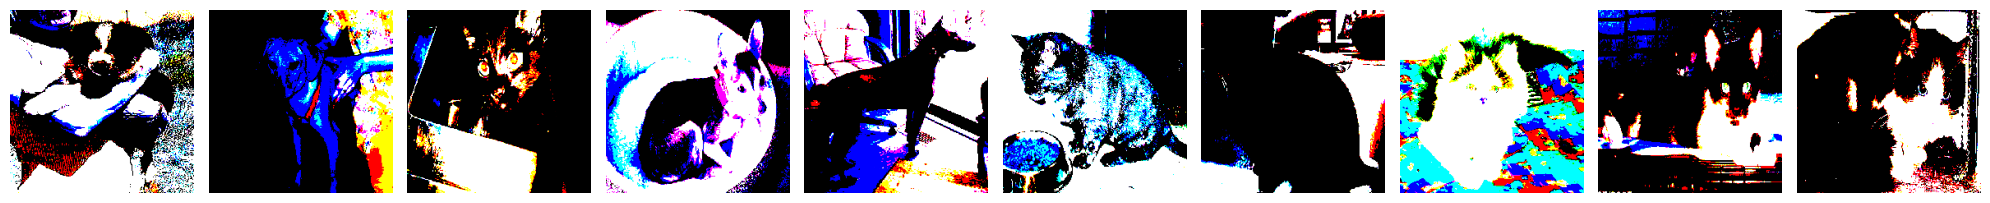

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

# Building and Training a CNN

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

* First layer in the model is a 2-dimensional convolutional layer. This layer will have 32 output filters each with a kernel size of 3x3, and we'll use the relu activation function

* Kernel size of 3x3 is generally a very common size to use

* On the first layer only, we also specify the input_shape, which is the shape of our data. Our images are 224 pixels high and 224 pixels wide and have 3 color channels: RGB. This gives us an input_shape of (224,224,3).

* We then add a max pooling layer to pool and reduce the dimensionality of the data.

* We then Flatten the output from the convolutional layer and pass it to a Dense layer. This Dense layer is theoutput layer of the network, and so it has 2 nodes, one for cat and one for dog.

* We'll use the softmax activation function on our output so that the output for each sample is a probability distribution over the outputs of cat and dog.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(x=train_batches,
#     steps_per_epoch=len(train_batches),
#     validation_data=valid_batches,
#     validation_steps=len(valid_batches),
#     epochs=10,
#     verbose=2
# )

In [15]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kaggle/dogs-vs-cats/dogs_vs_cats_model.keras')

In [16]:
model.save('/content/drive/MyDrive/kaggle/dogs-vs-cats/dogs_vs_cats_model.keras')

# Making predictions

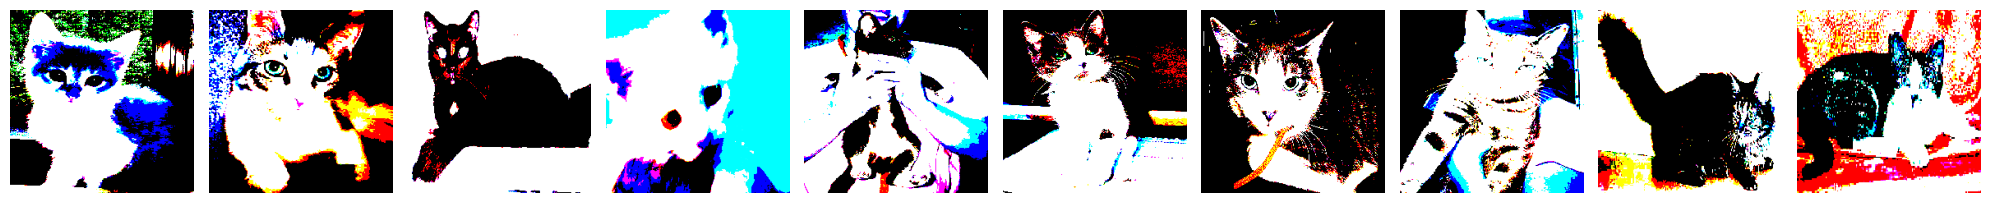

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [17]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [18]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [19]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [20]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [21]:
# Plotting a confusion matrix

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[33 17]
 [20 30]]


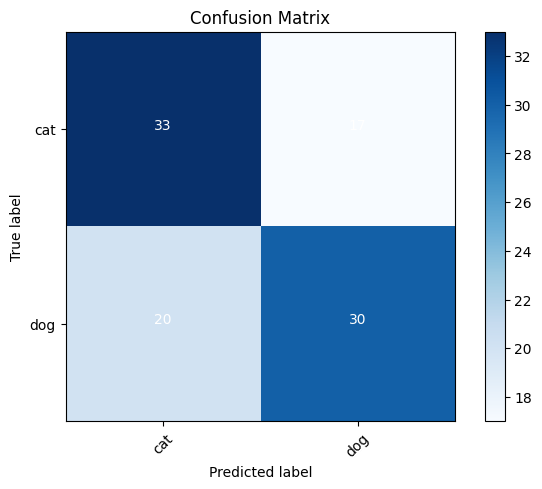

In [24]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

This plot clearly shows that there is a overfitting problem with this model. If this was a model we actually cared about, we would definitely try to improve the validation/test accuracy. But for now, we will be experimenting with a pre-trained model

# Data Augmentation

Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.

Example:

*   Flipping/Rotating/Cropping the image
*   Zooming in/out of the image
*   Changing the color of the image etc.



In [25]:
# Using many options to augment our data
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True)

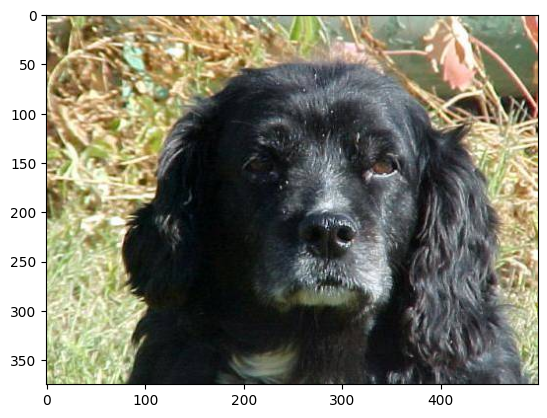

In [26]:
chosen_image = random.choice(os.listdir('/content/drive/MyDrive/kaggle/dogs-vs-cats/train/dog'))
image_path = '/content/drive/MyDrive/kaggle/dogs-vs-cats/train/dog/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [27]:
# Generate batches of augmented images from the original image
aug_iter = gen.flow(image)

In [28]:
# Get ten samples of the augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

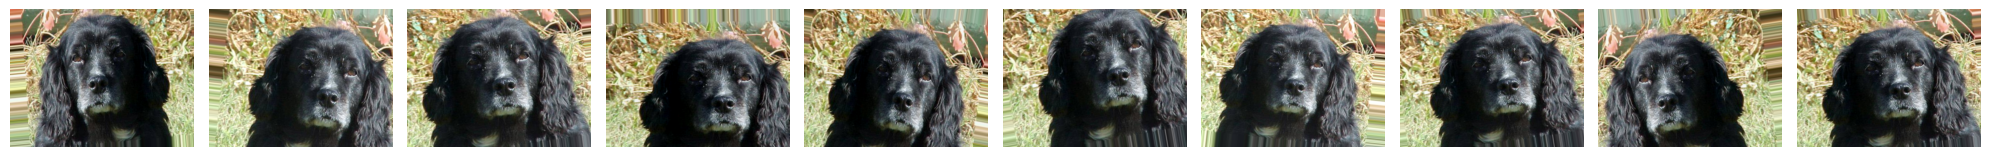

In [29]:
# Augmented images.
plotImages(aug_images)

# Building a Fine-Tuned Neural Network

## VGG16 & ImageNet

VGG16 pre-processing: The only preprocessing done is subtracting the mean RGB value, computed on the training set, from each pixel.

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
vgg16_model.summary()

In [ ]:
type(vgg16_model)

In [ ]:
# For now, I am going to go through a process to convert the Functional model to a Sequential model,
# so that it will be easier for me to work with given my current knowledge.

# First create a new model of type Sequential.
# Then iterate over each of the layers in vgg16_model, except for the last layer, and add each layer to the new Sequential model.

model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
model.summary()

In [ ]:
# Freezing all layers

# Iterate over each of the layers in our new Sequential model and set them to be non-trainable.
# This freezes the weights and other trainable parameters in each layer so that they will not be trained or
# updated when we later pass in our images of cats and dogs.

for layer in model.layers:
    layer.trainable = False

In [ ]:
# Adding new output layer, consisting of only 2 nodes that correspond to cat and dog.
# This output layer will be the only trainable layer in the model.

model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.summary()

## Training the Fine-Tuned VGG16 model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

In [31]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kaggle/dogs-vs-cats/dogs_vs_cats_fine_tuned_model.keras')

In [32]:
model.save('/content/drive/MyDrive/kaggle/dogs-vs-cats/dogs_vs_cats_fine_tuned_model.keras')

## Making Predictions using the Fine Tuned VGG16 model

In [33]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [34]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Confusion matrix, without normalization
[[50  0]
 [ 1 49]]


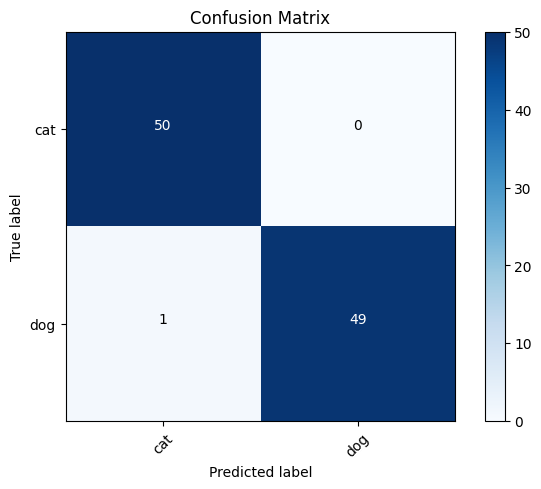

In [35]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')